In [1]:
import pyvista as pv
import PVGeo
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
import shapefile
from sklearn.neighbors import KDTree as Tree
import os

In [2]:
assert os.path.isdir("data")

In [3]:
!ls ./data

Negro_Mag_Fault_vertices.csv             model
Opal_Mound_Fault_vertices.csv            temperature_model.sgems
Roosevelt Hot Springs FORGE Site Outline top_granitoid_vertices.csv
geology-aerial-compressed.png            well_based_temperature.csv
land_surface_vertices.csv


## Surfaces

Remember the surface data types from the presentation? Let's make some from raw data files we were given!

In [4]:
topo_df = pd.read_csv("data/land_surface_vertices.csv")
topo_df.head()

,x,y,z
0,329924.988160,4.270951e+06,1493.691650
1,329924.988160,4.270926e+06,1493.996460
2,329949.993331,4.270926e+06,1493.786011
3,329949.993331,4.270951e+06,1493.691650
4,329974.998501,4.270926e+06,1493.790039


Looks like we have some simple `X, Y, Z` vertices, let's make a point cloud, then triangulate them into a surface mesh

In [5]:
topo = pv.PolyData(topo_df.values).delaunay_2d()
topo

PolyData,Information
N Cells,824278
N Points,413250
X Bounds,"3.299e+05, 3.442e+05"
Y Bounds,"4.253e+06, 4.271e+06"
Z Bounds,"1.494e+03, 2.723e+03"
N Arrays,0


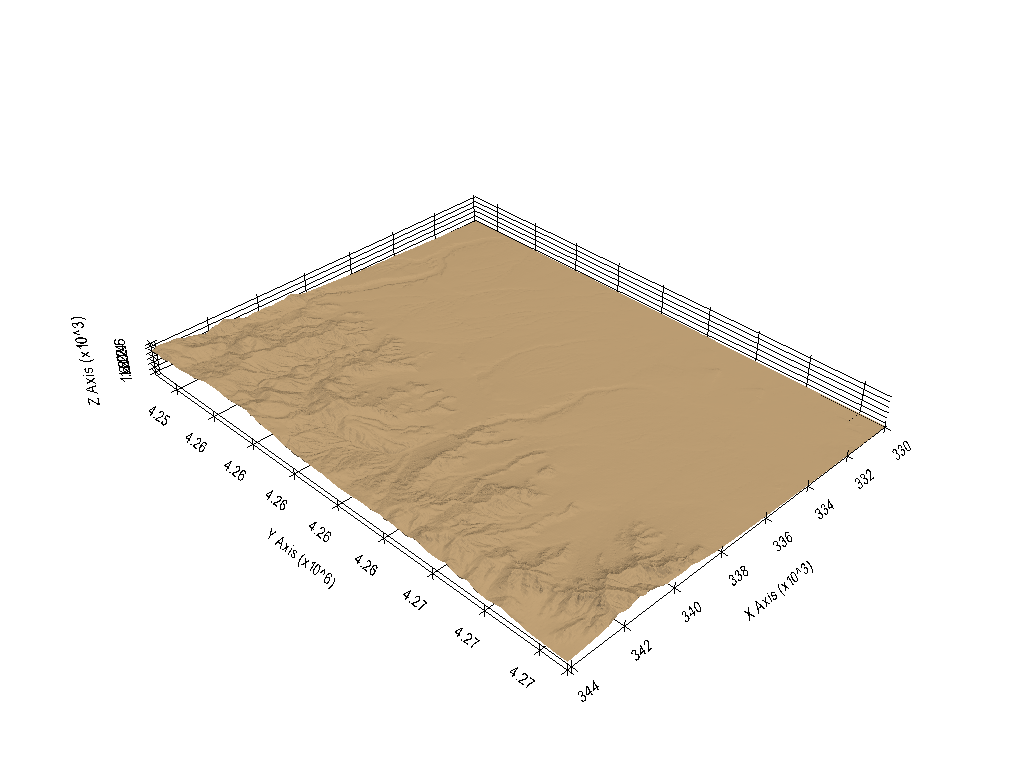

In [6]:
topo.plot(notebook=True, show_grid=True)

Now let's do the same thing for all the other surfaces given by defining a simple function.

In [7]:
read_surf = lambda f: pv.PolyData(pd.read_csv(f).values).delaunay_2d()

granite_raw = read_surf("data/top_granitoid_vertices.csv")
negro = read_surf("data/Negro_Mag_Fault_vertices.csv")
opal = read_surf("data/Opal_Mound_Fault_vertices.csv")

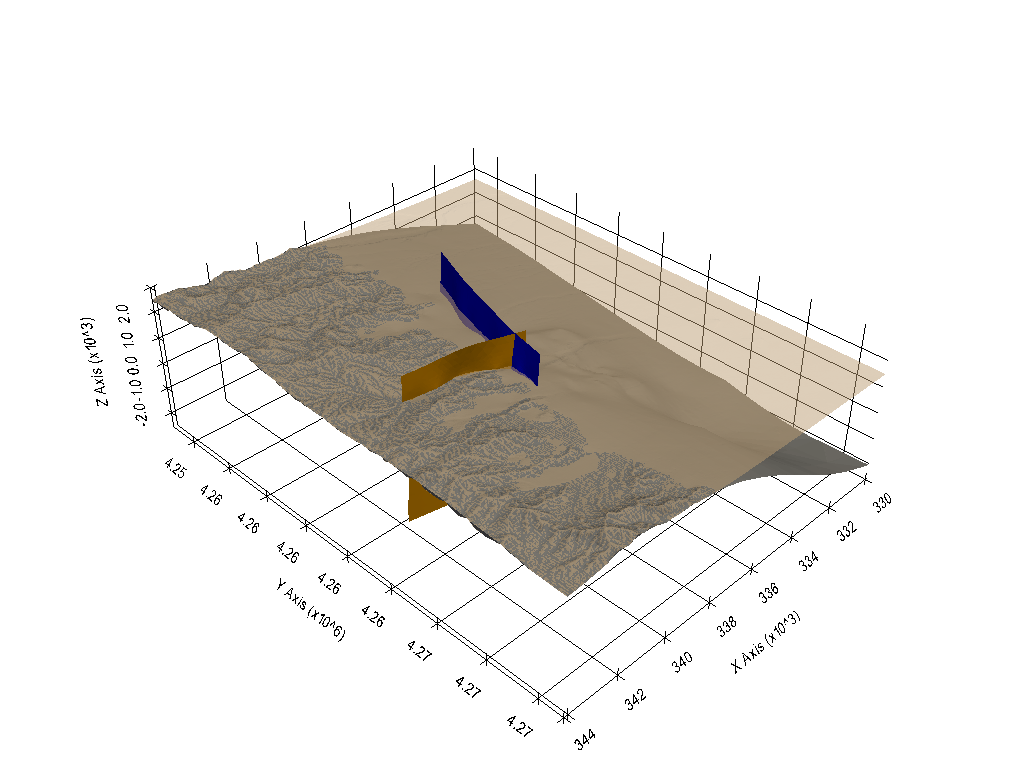

In [8]:
p = pv.Plotter()
p.add_mesh(granite_raw, color="gray")
p.add_mesh(negro, color="orange")
p.add_mesh(opal, color="blue")
p.add_mesh(topo, color="tan", opacity=0.5)
p.show_grid()
p.show()

Hm. It looks like the granite and the topography overlap. Let's fix that by clipping the granite surface by the topography surface.

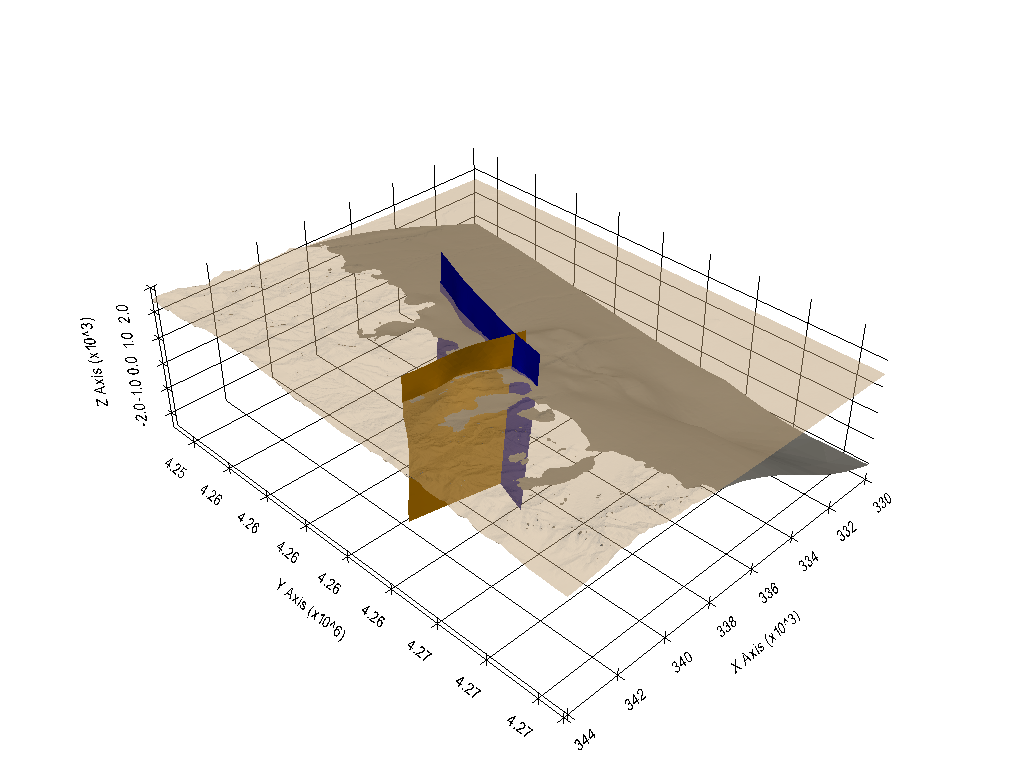

In [9]:
granite = granite_raw.clip_surface(topo, invert=False, value=2.0)

p = pv.Plotter()
p.add_mesh(granite, color="gray")
p.add_mesh(negro, color="orange")
p.add_mesh(opal, color="blue")
p.add_mesh(topo, color="tan", opacity=0.5)
p.show_grid()
p.show()

Much better!

## Geological Map

We were also given a PNG file of a geological map. Remember how PNG images are not truly "digital" data but "paleodigital"? That's because the spatial reference of a PNG is unknown. You'd have to have some accompanying meta data to define the spatial reference. In this case, we know the image to the follow UV coordinates:

```
origin = [310967.75148705, 4238841.04545394, 0.]
axis_u = [47715.1849411, 0., 0.]
axis_v = [0., 37440.94209864, 0.]
```

In [10]:
origin = np.array([310967.75148705, 4238841.04545394, 0.])
point_u = origin + np.array([47715.1849411, 0., 0.])
point_v = origin + np.array([0., 37440.94209864, 0.])
filename = "data/geology-aerial-compressed.png"

There are a few different ways that we can read this image

- As a raw NumPy array
- As a `pyvista.Texture` object for plotting
- and more...

In [11]:
# read as a NumPy array
img = imageio.imread(filename)
img.dtype, img.shape

(dtype('uint8'), (8769, 11175, 4))

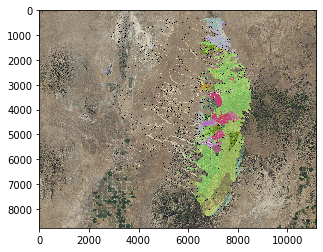

In [12]:
plt.imshow(img)

In [13]:
# Or read as a texture for PyVista
texture = pv.read_texture(filename)
texture

(Texture)0x7ffb9a49b948

So now that we have the image loaded as a texture, we need to associate it with the topography surface so that it can be display ontop of the topography. To do so, we use the UV coordinates defineed above with `pyvista`'s `texture_map_to_plane` method.

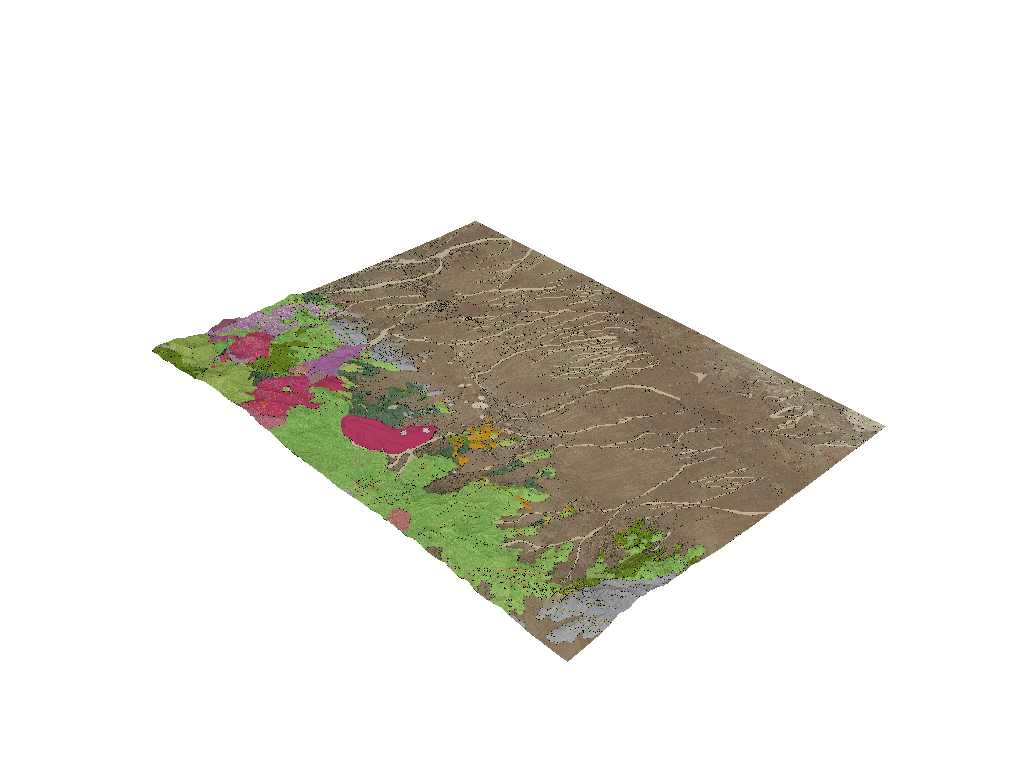

In [14]:
# Perfrom the texture mapping
topo_tex = topo.texture_map_to_plane(origin, point_u, point_v)
# Associate that texture
topo_tex.textures["map"] = texture

p = pv.Plotter(notebook=True)
p.add_mesh(topo_tex)
p.show()

## Point Clouds of Data

Let's check out the `well_based_temperature.csv` file

In [15]:
temp_df = pd.read_csv("data/well_based_temperature.csv")
temp_df.head()

,x,y,z,T
0,339385.01,4264212.99,1680.6,150.0
1,339385.01,4264212.99,880.6,195.0
2,339385.01,4264212.99,-119.4,195.0
3,337709.02,4260660.00,1596.3,250.0
4,337709.02,4260660.00,796.3,262.0


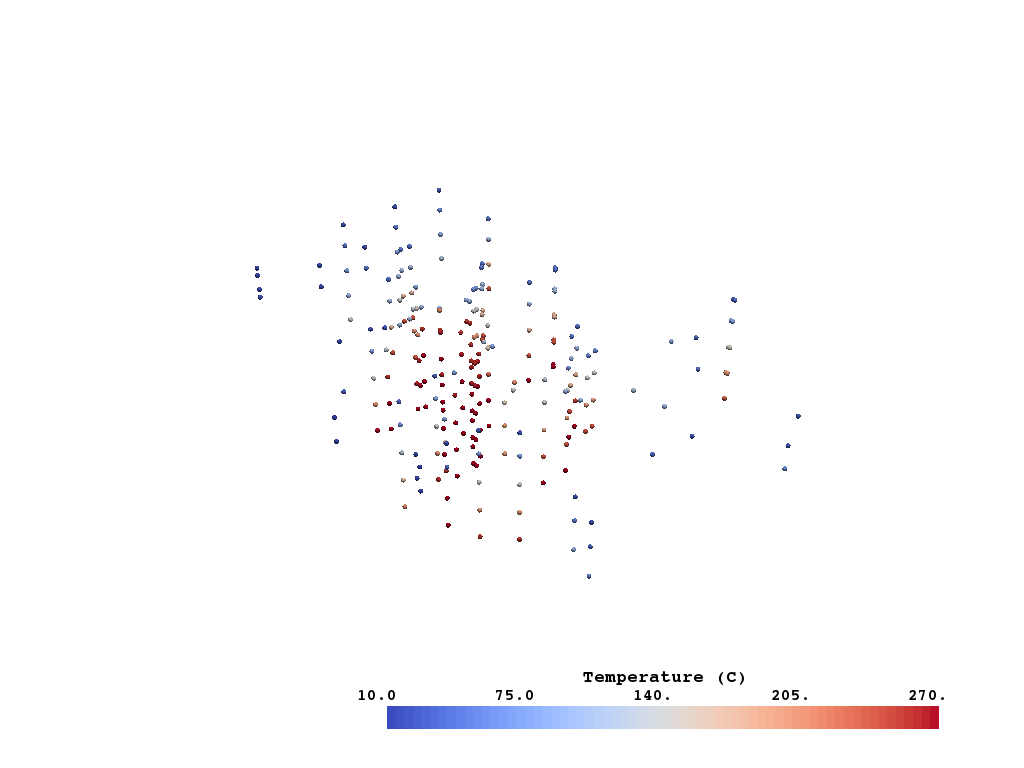

In [16]:
temp = pv.PolyData(temp_df[["x", "y", "z"]].values)
temp["Temperature (C)"] = temp_df["T"]
temp.plot(cmap="coolwarm", render_points_as_spheres=True)

## Shape Files

We were also given some shape files in the `Roosevelt Hot Springs FORGE Site Outline` directory, so let's deal with those too

In [17]:
filename = "data/Roosevelt Hot Springs FORGE Site Outline/FORGE_Outline"
shp = shapefile.Reader(filename)
records = shp.shapeRecords()
records

ShapeRecords: [<shapefile.ShapeRecord object at 0x7ffba9b294e0>]

In [18]:
shape = records[0].shape
shape.shapeType == shapefile.POLYGON

True

In [19]:
def _fix_to_topography(topo_points, points_to_update, static=20.0):
    """Update the z component of points to force them to lie on a topo surface"""
    tree = Tree(topo_points)
    ind = tree.query(points_to_update, k=1)[1].ravel()
    # Now update the elevation to be on the topo surface
    # Also shift it so its always just above the surface and not in the surface
    points_to_update[:,2] = topo_points[:,2][ind] + static
    return points_to_update


def polygon_to_vtk(polygon, topo_points):
    """Converts a polygon shape to a pyvista.PolyData object.
    This assumes the points are ordered.
    """
    pts = np.array(polygon.points)
    pts = np.c_[pts, np.zeros(pts.shape[0])]
    pts = _fix_to_topography(topo_points, pts)
    return pv.lines_from_points(pts)
    

boundary = polygon_to_vtk(shape, topo.points)
boundary

PolyData,Information
N Cells,10
N Points,11
X Bounds,"3.329e+05, 3.361e+05"
Y Bounds,"4.261e+06, 4.265e+06"
Z Bounds,"1.600e+03, 1.730e+03"
N Arrays,0


## Put it all Together


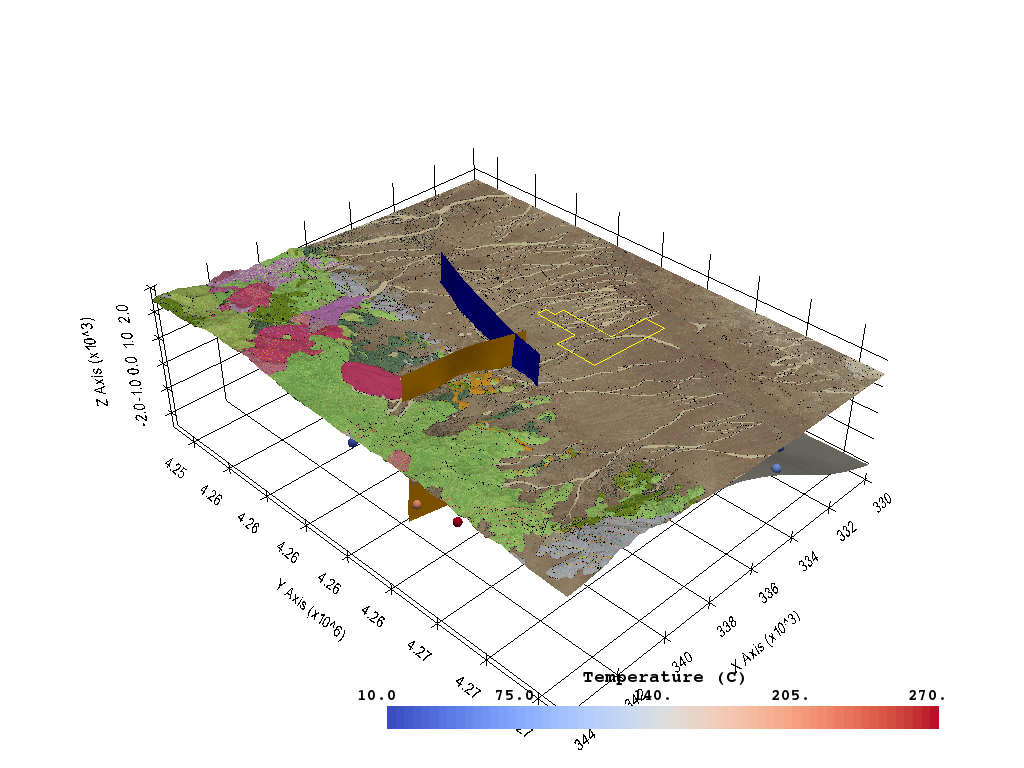

In [31]:
p = pv.Plotter(notebook=True)
p.add_mesh(topo_tex)
p.add_mesh(temp, cmap="coolwarm", render_points_as_spheres=True, point_size=10)
p.add_mesh(granite, color="gray")
p.add_mesh(negro, color="orange")
p.add_mesh(opal, color="blue")
p.add_mesh(boundary, color="yellow")
p.show_grid()
p.show()

## 3D Model

We were also given a 3D temperature model in GSLib format: `data/temperature_model.sgems`. There are file readers for this format in many software libraries, but it's useful to show how reading a custom file format can be done using `pandas`.

It's also important to note that the GSLib/SGeMS format is a well used standard but it is still not a "digital" format. The spatial reference of the grid given is totally absent and typically given in a readme file with the data. In this case, the origin and spacing of the gird are given as:

```
origin = [325000., 4.245e6, -2700]
spacing = [250, 250, 50]
```

In [21]:
!head data/model/Geotherm_kriged_0_krig_var.sgems

In [22]:
!head data/temperature_model.sgems

100 160 100
2
Temperature (C)	
variance
107.475448608	11614.9433594
107.438682556	11599.2001953
114.550773621	11703.9541016
114.49145507799999	11686.5986328
114.429496765	11668.7558594
114.364952087	11650.4462891


So it appears we have a header, the number of data arrays, the data titles, then the data arrays as a table.

In [23]:
with open("data/temperature_model.sgems", "r") as f:
    extent = [int(d) for d in f.readline().strip().split()]
    n_arrays = int(f.readline().strip())
    titles = []
    for i in range(n_arrays):
        titles.append(f.readline().strip())
    model_df = pd.read_table(f, names=titles, delim_whitespace=True)
model_df.head()

,Temperature (C),variance
0,107.475449,11614.943359
1,107.438683,11599.200195
2,114.550774,11703.954102
3,114.491455,11686.598633
4,114.429497,11668.755859


In [24]:
# Now make a grid
model = pv.UniformGrid()
model.dimensions = np.array(extent) + 1
model.spacing = [250, 250, 50]
model.origin = [325000., 4.245e6, -2700]
for name in model_df.keys():
    model[name] = model_df[name].values
model

UniformGrid (0x7ffba9b49948)
  N Cells:	1600000
  N Points:	1642361
  X Bounds:	3.250e+05, 3.500e+05
  Y Bounds:	4.245e+06, 4.285e+06
  Z Bounds:	-2.700e+03, 2.300e+03
  Dimensions:	101, 161, 101
  Spacing:	2.500e+02, 2.500e+02, 5.000e+01
  N Arrays:	2

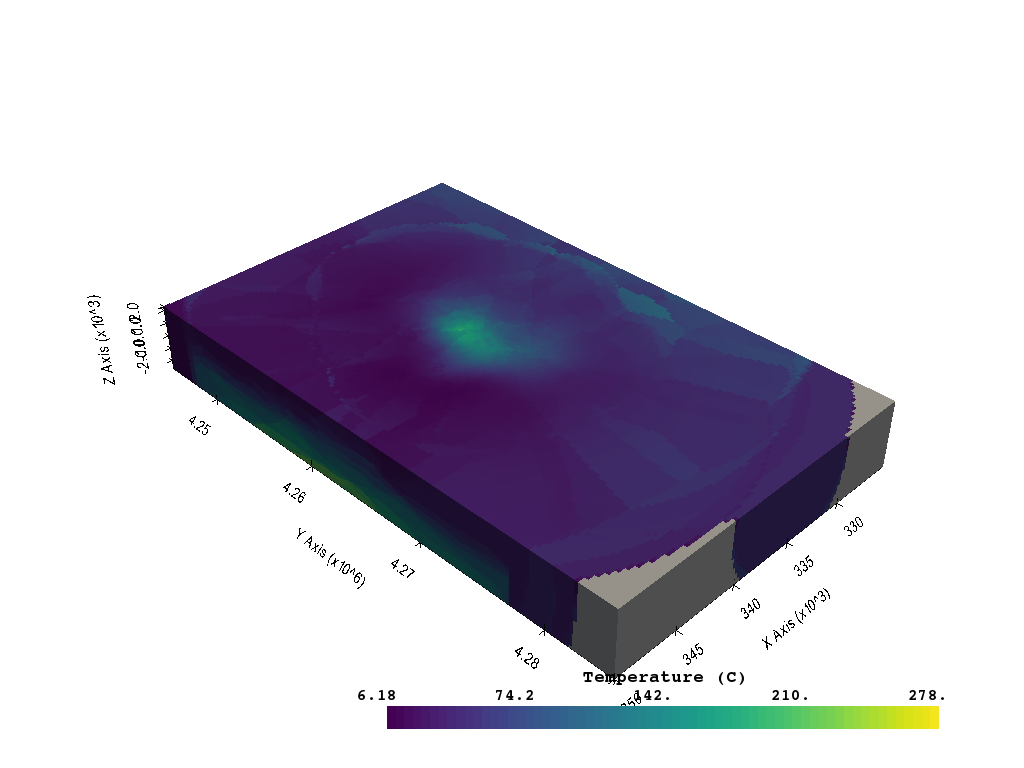

In [25]:
model.plot(show_grid=True)

This model has a massive spatial extent. Let's clip it down to our region of interest.

In [26]:
box = topo.bounds
box[4:6] = model.bounds[4:6]
voi = model.clip_box(box, invert=False)
voi

UnstructuredGrid (0x7ffb68810468)
  N Cells:	2751996
  N Points:	548393
  X Bounds:	3.298e+05, 3.442e+05
  Y Bounds:	4.253e+06, 4.271e+06
  Z Bounds:	-2.700e+03, 2.300e+03
  N Arrays:	2

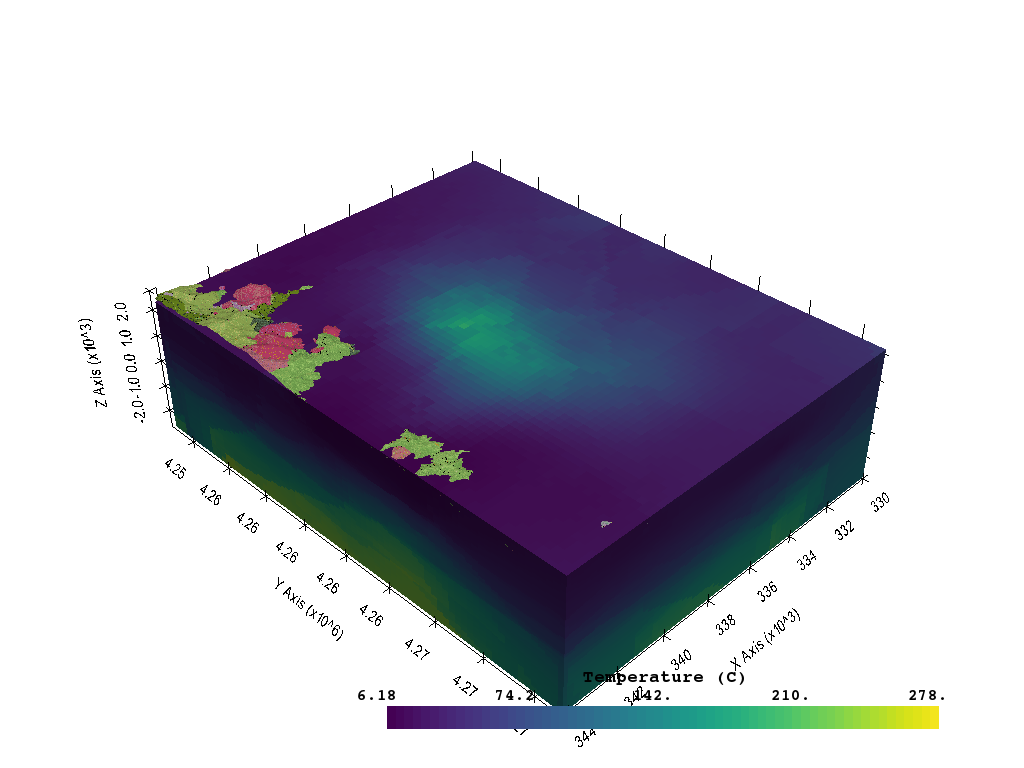

In [27]:
p = pv.Plotter(notebook=True)
p.add_mesh(topo_tex)
p.show_grid()
p.add_mesh(voi)
p.show()

Okay, but our model still show's data above the topography surface. Let's remove that.

In [28]:
subsurface = PVGeo.grids.ExtractTopography(
            remove=True, # remove the inactive cells
            tolerance=20.0 # buffer around the topo surface
           ).apply(voi, topo)
subsurface

UnstructuredGrid (0x7ffb68810ca8)
  N Cells:	2481072
  N Points:	472076
  X Bounds:	3.299e+05, 3.442e+05
  Y Bounds:	4.253e+06, 4.271e+06
  Z Bounds:	-2.700e+03, 2.300e+03
  N Arrays:	3

## The Final Scene

In [32]:
p = pv.Plotter(notebook=False)
p.add_mesh(topo_tex)
p.add_mesh(temp, cmap="coolwarm", render_points_as_spheres=True, point_size=10)
p.add_mesh(granite, color="gray")
p.add_mesh(negro, color="orange")
p.add_mesh(opal, color="blue")
p.show_grid()
p.add_mesh(boundary, color="yellow")
p.add_mesh_threshold(subsurface, cmap="coolwarm")
p.show()

[(377786.34117687267, 4279119.354689072, 11964.77429933589),
 (337038.96283, 4261892.29012, 103.0),
 (-0.28170838615134036, 0.005671526116100167, 0.9594833083298124)]

## Environment

In [30]:
pv.Report(["PVGeo", "shapefile", "pandas", "sklearn"], sort=True)

--------------------------------------------------------------------------------
  Date: Sun Nov 17 18:38:28 2019 MST

            Darwin : OS
                12 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           32.0 GB : RAM
           Jupyter : Environment

  Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56)
  [Clang 4.0.1 (tags/RELEASE_401/final)]

             2.1.0 : PVGeo
             2.1.0 : shapefile
            0.25.2 : pandas
            0.21.3 : sklearn
            0.22.4 : pyvista
             8.1.2 : vtk
            1.17.2 : numpy
             2.6.1 : imageio
             1.4.3 : appdirs
             0.4.3 : scooby
             3.1.1 : matplotlib
            5.12.3 : PyQt5
             7.6.1 : IPython
             7.5.1 : ipywidgets
--------------------------------------------------------------------------------